# CS441 Final Project: **FaceOrFilm**

Longwei Zhang  
Netid: longwei2  
Email: longwei2@illinois.edu  
Github: https://github.com/Longweizh/FaceOrFilm  

## Dataset

In [22]:
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset


class ImageDataset(Dataset):
    """
    Read from CSV with columns:
        filename, persons, film_brand, film_type, gf_label, split
    output binary gf_label (0/1)
    """

    def __init__(self, csv_path, raw_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.raw_dir = Path(raw_dir)
        self.transform = transform


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        filename = row["filename"]
        label = int(row["gf_label"])

        img_path = self.raw_dir / filename

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

## Data Config

In [23]:
# ================ Configuration ==================
RAW_DIR = "../raw_photos"
SPLIT_DIR = "../splits_by_yimeng"

TRAIN_CSV = f"{SPLIT_DIR}/gf_binary_train.csv"
VAL_CSV = f"{SPLIT_DIR}/gf_binary_val.csv"
TEST_CSV = f"{SPLIT_DIR}/gf_binary_test.csv"

OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

BATCH_SIZE = 16
LR = 1e-4
NUM_EPOCHS = 10
RANDOM_SEED = 42
NUM_WORKERS = 4

## Show image 

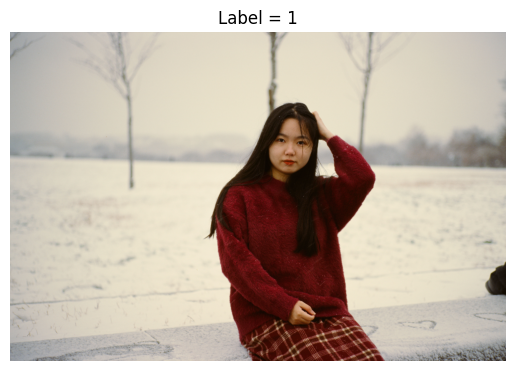

In [24]:
import matplotlib.pyplot as plt

def show_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # C,H,W → H,W,C
    img = (img * 0.229 + 0.485, img * 0.224 + 0.456, img * 0.225 + 0.406)
    return img

def image(number=0):
    ds = ImageDataset(TRAIN_CSV, RAW_DIR, transform=None)
    img, label = ds[number]
    plt.imshow(img)
    plt.title(f"Label = {label}")
    plt.axis("off")
    plt.show()


image(0)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt



# ===================== 配置 ======================
RAW_DIR = "../raw_photos"
SPLIT_DIR = "../splits_by_yimeng"

TRAIN_CSV = f"{SPLIT_DIR}/gf_binary_train.csv"
VAL_CSV = f"{SPLIT_DIR}/gf_binary_val.csv"
TEST_CSV = f"{SPLIT_DIR}/gf_binary_test.csv"

OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

BATCH_SIZE = 16
LR = 1e-4
NUM_EPOCHS = 10
RANDOM_SEED = 42
NUM_WORKERS = 4
# =================================================


def compute_class_weight(csv_path):
    """根据训练集的 gf_label 统计样本数，算 class weight"""
    df = pd.read_csv(csv_path)
    counts = df["gf_label"].value_counts().sort_index()
    # counts[0] = not_gf, counts[1] = gf

    w0 = 1.0 / counts[0]
    w1 = 1.0 / counts[1]
    weights = torch.tensor([w0, w1], dtype=torch.float32)
    weights = weights / weights.mean()

    print("Class counts:", counts.to_dict())
    print("Class weights:", weights.tolist())
    return weights


def get_loaders():
    """基于 CSV 构建 train/val/test 的 DataLoader"""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_ds = ImageDataset(TRAIN_CSV, RAW_DIR, transform=train_tf)
    val_ds = ImageDataset(VAL_CSV, RAW_DIR, transform=eval_tf)
    test_ds = ImageDataset(TEST_CSV, RAW_DIR, transform=eval_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True)

    return train_loader, val_loader, test_loader


def build_model():
    """ResNet18 预训练 + 替换最后一层为 2 类"""
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)
    return model


def _update_confusion(preds, labels, tp, fp, fn, tn):
    """更新 TP / FP / FN / TN（针对 gf_label=1 的二分类）"""
    preds = preds.view(-1)
    labels = labels.view(-1)
    tp += ((preds == 1) & (labels == 1)).sum().item()
    fp += ((preds == 1) & (labels == 0)).sum().item()
    fn += ((preds == 0) & (labels == 1)).sum().item()
    tn += ((preds == 0) & (labels == 0)).sum().item()
    return tp, fp, fn, tn


def _compute_metrics(total_loss, correct, total, tp, fp, fn, tn):
    """根据累计量计算 loss, acc, precision, recall, f1"""
    loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)

    precision = tp / max(tp + fp, 1e-8)
    recall = tp / max(tp + fn, 1e-8)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)

    return {
        "loss": loss,
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "total": total,
    }


def run_one_epoch(model, loader, criterion, optimizer, device, train: bool):
    """
    统一的 epoch 函数：
    - train=True: 训练模式 + 反向传播
    - train=False: 评估模式
    """
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0
    tp = fp = fn = tn = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            if train:
                loss.backward()
                optimizer.step()

        preds = outputs.argmax(dim=1)

        total_loss += loss.item() * imgs.size(0)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

        tp, fp, fn, tn = _update_confusion(preds, labels, tp, fp, fn, tn)

    metrics = _compute_metrics(total_loss, correct, total, tp, fp, fn, tn)
    return metrics


def plot_curves(history_df: pd.DataFrame, out_dir: Path):
    """根据 history_df 画 Loss 和 ACC/Recall/F1 曲线"""
    # Loss 曲线
    plt.figure()
    plt.plot(history_df["epoch"], history_df["train_loss"], label="train_loss")
    plt.plot(history_df["epoch"], history_df["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.tight_layout()
    plt.savefig(out_dir / "loss_curve.png")
    plt.close()

    # Accuracy / Recall / F1 曲线（validation）
    plt.figure()
    plt.plot(history_df["epoch"], history_df["val_acc"], label="val_acc")
    plt.plot(history_df["epoch"], history_df["val_recall"], label="val_recall")
    plt.plot(history_df["epoch"], history_df["val_f1"], label="val_f1")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.title("Validation Metrics")
    plt.tight_layout()
    plt.savefig(out_dir / "val_metrics_curve.png")
    plt.close()


def main():
    torch.manual_seed(RANDOM_SEED)

    train_loader, val_loader, test_loader = get_loaders()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    model = build_model().to(device)

    class_weight = compute_class_weight(TRAIN_CSV).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_val_acc = 0.0
    best_model_path = OUTPUT_DIR / "best_model_resnet18_csv.pth"

    # 记录每个 epoch 的指标，方便保存 CSV & 画图
    history = []

    for epoch in range(1, NUM_EPOCHS + 1):
        # 训练阶段
        train_metrics = run_one_epoch(model, train_loader, criterion, optimizer, device, train=True)
        # 验证阶段
        val_metrics = run_one_epoch(model, val_loader, criterion, optimizer, device, train=False)

        print(
            f"Epoch {epoch:02d}: "
            f"Train Loss={train_metrics['loss']:.4f}, Acc={train_metrics['acc']:.4f} | "
            f"Val Loss={val_metrics['loss']:.4f}, Acc={val_metrics['acc']:.4f}, "
            f"Recall={val_metrics['recall']:.4f}, F1={val_metrics['f1']:.4f}"
        )

        # 记录到 history
        history.append({
            "epoch": epoch,
            "train_loss": train_metrics["loss"],
            "train_acc": train_metrics["acc"],
            "train_precision": train_metrics["precision"],
            "train_recall": train_metrics["recall"],
            "train_f1": train_metrics["f1"],
            "val_loss": val_metrics["loss"],
            "val_acc": val_metrics["acc"],
            "val_precision": val_metrics["precision"],
            "val_recall": val_metrics["recall"],
            "val_f1": val_metrics["f1"],
        })

        # 保存 val_acc 最好的模型
        if val_metrics["acc"] > best_val_acc:
            best_val_acc = val_metrics["acc"]
            torch.save(model.state_dict(), best_model_path)
            print(f"  ✔ Saved new best model (val_acc={best_val_acc:.4f})")

    # 把 history 存成 CSV，方便你以后画图/进报告
    history_df = pd.DataFrame(history)
    history_csv_path = OUTPUT_DIR / "training_history.csv"
    history_df.to_csv(history_csv_path, index=False)
    print(f"\n训练过程指标已保存到: {history_csv_path}")

    # 画 Loss & Metrics 曲线
    plot_curves(history_df, OUTPUT_DIR)
    print(f"Loss 曲线 / Val 指标曲线已保存到: {OUTPUT_DIR}")

    # 用最优模型在 test set 上做一次最终测试
    print("\nEvaluating best model on test set...")
    model.load_state_dict(torch.load(best_model_path))
    test_metrics = run_one_epoch(model, test_loader, criterion, optimizer=None, device=device, train=False)

    print(
        f"Test: Loss={test_metrics['loss']:.4f}, "
        f"Acc={test_metrics['acc']:.4f}, "
        f"Precision={test_metrics['precision']:.4f}, "
        f"Recall={test_metrics['recall']:.4f}, "
        f"F1={test_metrics['f1']:.4f}"
    )

    print("Done.")


if __name__ == "__main__":
    main()

Device: cuda
Class counts: {0: 1076, 1: 212}
Class weights: [0.32919251918792725, 1.6708073616027832]
Epoch 01: Train Loss=0.4352, Acc=0.7896 | Val Loss=0.2956, Acc=0.8406, Recall=0.9111, F1=0.6508
  ✔ Saved new best model (val_acc=0.8406)
Epoch 02: Train Loss=0.3431, Acc=0.8781 | Val Loss=0.1449, Acc=0.9493, Recall=0.9556, F1=0.8600
  ✔ Saved new best model (val_acc=0.9493)
Epoch 03: Train Loss=0.2853, Acc=0.8967 | Val Loss=0.3700, Acc=0.9275, Recall=0.5778, F1=0.7222
Epoch 04: Train Loss=0.2605, Acc=0.9022 | Val Loss=0.1122, Acc=0.9457, Recall=0.9556, F1=0.8515
Epoch 05: Train Loss=0.2161, Acc=0.9169 | Val Loss=0.1519, Acc=0.9529, Recall=0.9111, F1=0.8632
  ✔ Saved new best model (val_acc=0.9529)
Epoch 06: Train Loss=0.2619, Acc=0.9224 | Val Loss=0.3431, Acc=0.9420, Recall=0.7556, F1=0.8095
Epoch 07: Train Loss=0.2366, Acc=0.9123 | Val Loss=0.1380, Acc=0.9674, Recall=0.9111, F1=0.9011
  ✔ Saved new best model (val_acc=0.9674)
Epoch 08: Train Loss=0.1945, Acc=0.9356 | Val Loss=0.1312,

## Analysis the results

In [27]:
import shutil
import os


# ======== 配置区域 ========
RAW_DIR = Path("../raw_photos")              # 原始图片目录
TEST_CSV = Path("../splits_by_yimeng/gf_binary_test.csv")  # test 划分的 CSV
MODEL_PATH = Path("../outputs/best_model_resnet18_csv.pth")  # 之前训练好的模型
OUT_DIR = Path("../outputs/misclassified")       # 错误样本输出目录
MAX_SAVE = 100  # 最多保存多少张错误样本，防止太多
# =========================


class TestDatasetWithFilename(Dataset):
    """
    和 CS441ImageDataset 类似，但额外返回 filename，方便可视化时知道是哪张图。
    CSV 需要包含: filename, gf_label
    """
    def __init__(self, csv_path, raw_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.raw_dir = Path(raw_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["filename"]
        label = int(row["gf_label"])

        img_path = self.raw_dir / filename
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label, filename


def build_model(num_classes=2):
    """和训练时保持一致：ResNet18 预训练 + 替换最后一层"""
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


def main():
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    # 图像预处理：和 eval 阶段一致
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    dataset = TestDatasetWithFilename(TEST_CSV, RAW_DIR, transform=eval_tf)
    loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # 构建模型并加载最优权重
    model = build_model(num_classes=2).to(device)
    state_dict = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    softmax = nn.Softmax(dim=1)

    mis_rows = []  # 记录错误样本信息，后面写 csv 用
    saved_count = 0

    with torch.no_grad():
        for imgs, labels, filenames in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            probs = softmax(outputs)          # [batch, 2]
            preds = outputs.argmax(dim=1)     # [batch]

            for i in range(len(filenames)):
                true_label = int(labels[i].item())
                pred_label = int(preds[i].item())
                filename = filenames[i]

                if true_label != pred_label:
                    prob_pred = float(probs[i, pred_label].item())

                    mis_rows.append({
                        "filename": filename,
                        "true_label": true_label,
                        "pred_label": pred_label,
                        "prob_pred": prob_pred,
                    })

                    # 把原始图片拷贝出来，文件名带上预测信息
                    if saved_count < MAX_SAVE:
                        src = RAW_DIR / filename
                        # 0 = not_gf, 1 = gf
                        true_tag = "gf" if true_label == 1 else "not_gf"
                        pred_tag = "gf" if pred_label == 1 else "not_gf"
                        dst_name = f"true-{true_tag}_pred-{pred_tag}_prob-{prob_pred:.3f}_{Path(filename).name}"
                        dst = OUT_DIR / dst_name

                        # 确保父目录存在
                        dst.parent.mkdir(parents=True, exist_ok=True)
                        shutil.copy2(src, dst)
                        saved_count += 1

    # 记录所有错误样本到 csv
    mis_df = pd.DataFrame(mis_rows)
    mis_csv_path = OUT_DIR / "misclassified_samples.csv"
    mis_df.to_csv(mis_csv_path, index=False)

    print(f"\n共发现 {len(mis_rows)} 个错误分类样本")
    print(f"已拷贝 {saved_count} 张图片到: {OUT_DIR.resolve()}")
    print(f"错误样本列表 CSV: {mis_csv_path.resolve()}")


if __name__ == "__main__":
    main()

Device: cuda


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x701a48d64820>
Traceback (most recent call last):
  File "/home/longwei/CS441/final/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/longwei/CS441/final/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x701a48d64820>
Traceback (most recent call last):
  File "/home/longwei/CS441/final/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/home/longwei/CS441/final/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _


共发现 14 个错误分类样本
已拷贝 14 张图片到: /home/longwei/CS441/final/outputs/misclassified
错误样本列表 CSV: /home/longwei/CS441/final/outputs/misclassified/misclassified_samples.csv
